# Salinity Setup:<br>Run Best Trial
***

In [1]:
import numpy as np
import pandas as pd 
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

import scipy.stats as st
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<br>

## 1. Load Data
***

**feat_pc:** Principal Components of climate indices. Used for model input.  
**labels:** from Sahelrainfall data serves as reference data.

In [2]:
features = xr.open_dataset('data/da_final_salinitymodel.nc').feat_pc.values
labels = xr.open_dataset('data/da_final_salinitymodel.nc').labels.values

<br>

## 2. MODEL SETUP
***

<br>

### Build Model Function
---

In [3]:
def BuildModel(HPARAMS):
    model = keras.Sequential([
#         layers.Dropout(0.1, input_shape=(22,)),
        layers.Dense(HPARAMS['n_units_l1'], 'relu' ,name="layer1", input_shape=(22,)),
        layers.Dropout(HPARAMS['dropout'], name='Dropout1'),
        
        layers.Dense(HPARAMS['n_units_l2'], 'relu', name="layer2"),
        layers.Dropout(HPARAMS['dropout'], name='Dropout2'),
        
        layers.Dense(HPARAMS['n_units_l3'], 'relu', name="layer3"),
        layers.Dropout(HPARAMS['dropout'], name='Dropout3'),
        
        layers.Dense(HPARAMS['n_units_l4'], 'relu', name="layer4"),
        layers.Dropout(HPARAMS['dropout'], name='Dropout4'),
        
        layers.Dense(HPARAMS['n_units_l5'], 'relu', name="layer5"),
        
        
        layers.Dense(1, name='output'), #activation='linear'
    ])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(
            learning_rate=HPARAMS['learn_rate']
        )
    )
    return model

<br>

### Hyperparameters
***

In [4]:
### choose parameters ###
HPARAMS = np.load('evaluation/salinitymodel/fourth.npy', allow_pickle=1).item()
print(HPARAMS)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

k = 10 # number of 'folds' -> sample size as in Badr


{'learn_rate': 0.0079946457462269, 'n_units_l1': 60, 'n_units_l2': 5, 'n_units_l3': 60, 'n_units_l4': 50, 'n_units_l5': 20, 'batch_size': 3, 'dropout': 0.1392507179728921}


<br>

## 3. Run Model
***

In [5]:
%%time

# define error metrics:
mae_train = []
mad_train = []
mse_train = []
rmse_train = []
corr_train = []

mae_test = []
mad_test = []
mse_test = []
rmse_test = []
corr_test = []

training_length = []

splits = [{'train': t, 'test': s} for t, s in KFold(n_splits=k, shuffle=True, random_state=712).split(features)]

for split in splits:                      #KFold

    train_index = shuffle(split['train'], random_state=712)
    test_index  = shuffle(split['test'], random_state=712)
    
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    # Build the model according to definition:
    model = BuildModel(HPARAMS)
    

    #Train the model 
    train_history = model.fit(
        features[train_index],
        labels[train_index],
        batch_size=HPARAMS['batch_size'],
        epochs=200,
        verbose=0,
        callbacks=earlystop
    )

    
    #Run the model for insample data:
    y_train= np.squeeze(model.predict(features[train_index]))
    
    # ... and for out of sample data
    y_test = np.squeeze(model.predict(features[test_index]))
    
    
    # save errors into numpy arrays:
    e_train =  y_train - labels[train_index]
    ae_train = np.absolute(e_train)
    mae_train = np.append(mae_train, np.mean(ae_train))
    mad_train = np.append(mad_train, np.median(np.absolute(e_train - np.median(e_train))))
    mse_train = np.append(mse_train, np.mean(e_train**2))
    rmse_train = np.append(rmse_train, np.sqrt(mse_train))
    corr_train = np.append(corr_train, st.pearsonr(y_train, labels[train_index])[0])
    
    
    e_test =  y_test - labels[test_index]
    ae_test = np.absolute(e_test)
    mae_test = np.append(mae_test, np.mean(ae_test))
    mad_test = np.append(mad_test, np.median(np.absolute(e_test - np.median(e_test))))
    mse_test = np.append(mse_test, np.mean(e_test**2))
    rmse_test = np.append(rmse_test, np.sqrt(mse_test))
    corr_test = np.append(corr_test, st.pearsonr(y_test, labels[test_index])[0])
    
    training_length = np.append(training_length, len(train_history.history['loss']))

CPU times: user 46 s, sys: 13.3 s, total: 59.4 s
Wall time: 22.2 s


<br>

## 4. Metrics
---

In [6]:
print('Training Correlation')
display(corr_train)
print('Test Correlation')
display(corr_test)
print('Training MSE')
display(mse_train)
print('Test MSE')
display(mse_test)

Training Correlation


array([0.91163923, 0.91755497, 0.94107668, 0.94069551, 0.95797755,
       0.96063549, 0.95792333, 0.92375325, 0.94875896, 0.9316189 ])

Test Correlation


array([ 0.46451194,  0.71334524, -0.08041814,  0.69048719,  0.23860956,
        0.51589467,  0.64447819,  0.32817655,  0.53250148,  0.72383518])

Training MSE


array([0.72442042, 0.71531701, 0.64865555, 1.17031411, 0.49661078,
       0.36238847, 0.37051388, 1.12044527, 0.44708212, 0.60057477])

Test MSE


array([4.10219699, 1.8067069 , 2.42313421, 1.33563813, 3.15480239,
       5.4519243 , 4.40211481, 3.58321295, 2.59106483, 1.94757839])

#### Training Errors

In [7]:
train_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.nanmean(corr_train)],
        'corr_sig': [np.std(corr_train)],
        'mad_mu': [np.mean(mad_train)],
        'mad_sig': [np.std(mad_train)],
        'mae_mu': [np.mean(mae_train)],
        'mae_sig': [np.std(mae_train)],
        'mse_mu': [np.mean(mse_train)],
        'mse_sig': [np.std(mse_train)],
        'rmse_mu': [np.mean(rmse_train)],
        'rmse_sig': [np.std(rmse_train)],
        'training_length_mu': [np.mean(training_length)],
        'training_length_sig': [np.std(training_length)],
    }
)
train_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig,training_length_mu,training_length_sig
0,0.939163,0.016685,0.421778,0.071207,0.604448,0.117168,0.665632,0.269701,0.819995,0.148428,43.4,11.191068


<br>

#### Test Errors

In [8]:
test_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_test)],
        'corr_sig': [np.std(corr_test)],
        'mad_mu': [np.mean(mad_test)],
        'mad_sig': [np.std(mad_test)],
        'mae_mu': [np.mean(mae_test)],
        'mae_sig': [np.std(mae_test)],
        'mse_mu': [np.mean(mse_test)],
        'mse_sig': [np.std(mse_test)],
        'rmse_mu': [np.mean(rmse_test)],
        'rmse_sig': [np.std(rmse_test)],
    }
)
test_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.477142,0.241838,1.055326,0.450145,1.436605,0.283391,3.079837,1.236717,1.707493,0.365287


<br>

## 5. PLot model output vs Validation Data
---

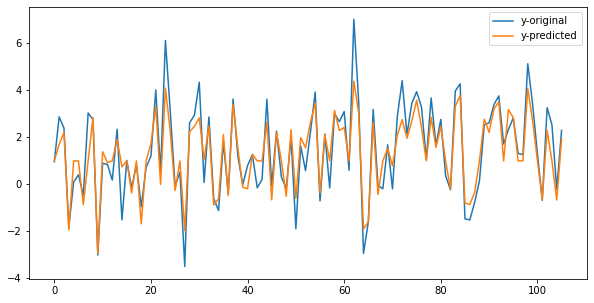

In [9]:
plt.figure(figsize=(10,5))
plt.plot(labels[train_index], label="y-original")
plt.plot(y_train, label="y-predicted")
plt.legend()
plt.show()

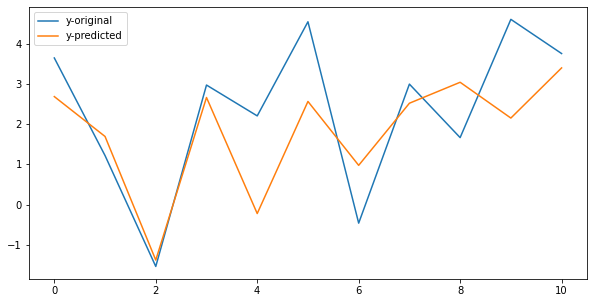

In [10]:
plt.figure(figsize=(10,5))
plt.plot(labels[test_index], label="y-original")
plt.plot(y_test, label="y-predicted")
plt.legend()
plt.show()

## 6. Save Model
---

In [11]:
# model.save('evaluation/salinitymodel/model.h5')   # !CAUTION! WILL OVERWRITE CURRENT SAVED MODEL